# Predicción si una página web es phishing o no, a través de redes neuronales

#### Importamos librerías

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns",None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader


#### Cargamos el csv

In [3]:
#Se carga el dataframe
df=pd.read_csv('data/dataset_phishing.csv')

In [4]:
#Su estructura
print(df)

                                                     url  length_url  \
0                  http://www.crestonwood.com/router.php          37   
1      http://shadetreetechnology.com/V4/validation/a...          77   
2      https://support-appleld.com.secureupdate.duila...         126   
3                                     http://rgipt.ac.in          18   
4      http://www.iracing.com/tracks/gateway-motorspo...          55   
...                                                  ...         ...   
11425      http://www.fontspace.com/category/blackletter          45   
11426  http://www.budgetbots.com/server.php/Server%20...          84   
11427  https://www.facebook.com/Interactive-Televisio...         105   
11428             http://www.mypublicdomainpictures.com/          38   
11429  http://174.139.46.123/ap/signin?openid.pape.ma...         477   

       length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  \
0                   19   0        3           0      0 

In [5]:
# Identificamos nulos
df.isnull().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [6]:
# Identificar duplicados en el DataFrame
df.duplicated()


0        False
1        False
2        False
3        False
4        False
         ...  
11425    False
11426    False
11427    False
11428    False
11429    False
Length: 11430, dtype: bool

In [7]:
# Eliminamos url 
df=df.drop(labels="url",axis=1)

In [8]:
df.select_dtypes(include='object').columns

Index(['status'], dtype='object')

In [9]:
# Seleccionar columnas de tipo 'object' en el DataFrame
object_features=[col for col in df.columns if df[col].dtype=="O"]
object_features

['status']

In [10]:
# Verificar los conteos de valores únicos en la columna 'status'
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

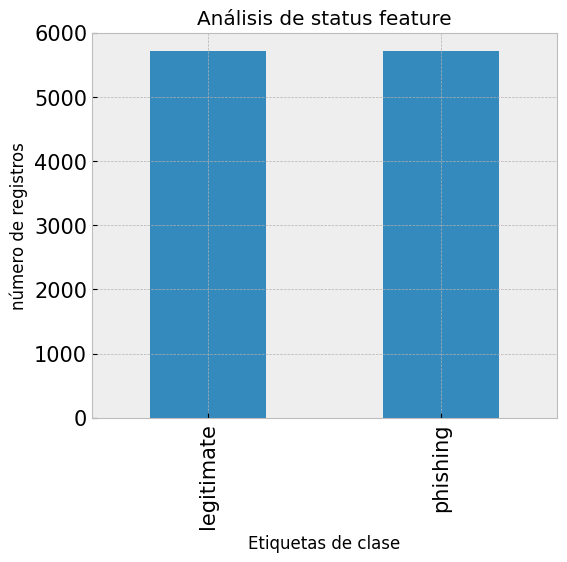

In [11]:
# Crear un gráfico de barras para visualizar los conteos de la columna 'status'
# Utilizando el estilo 'bmh' de Matplotlib
with plt.style.context(style="bmh"):
    fig=df['status'].value_counts().plot.bar(figsize=(6,5),
                                             fontsize=15,
                                             title='Análisis de status feature',
                                            xlabel='Etiquetas de clase',
                                            ylabel='número de registros')
    plt.show()

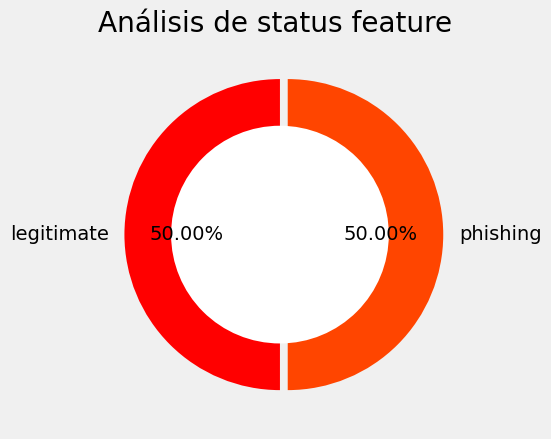

In [12]:
# Configuración del estilo de la trama con 'fivethirtyeight'
with plt.style.context(style="fivethirtyeight"):
    # Creación de un gráfico de pastel (pie chart) para la columna 'status'
    plt.pie(x=dict(df['status'].value_counts()).values(),
            labels=dict(df['status'].value_counts()).keys(),
            autopct="%.2f%%",
            colors=['red', 'orangered'],
            startangle=90,
            explode=[0, 0.05])

    # Creación de un círculo central para formar un gráfico de rosquilla (donut chart)
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Configuración del título de la trama
    plt.title(label="Análisis de status feature ")

    # Mostrar la trama
    plt.show()

In [13]:
# Obtener las etiquetas únicas de la columna 'status', convertirlas a una lista y ordenarlas
class_labels = df['status'].unique().tolist()
class_labels.sort()

# Imprimir las etiquetas ordenadas
print(class_labels)

['legitimate', 'phishing']


In [14]:
# Crear un diccionario para asignar índices a las etiquetas únicas
class_dict = {}

# Iterar sobre las etiquetas únicas y asignar un índice a cada una
for idx, label in enumerate(class_labels):
    class_dict[label] = idx

# Imprimir el diccionario resultante
print(class_dict)

{'legitimate': 0, 'phishing': 1}


In [15]:
# Codificación de etiquetas (label encoding)
df['status'] = df['status'].map(class_dict)
# Imprimir las primeras filas del DataFrame después de la codificación
df.head(5)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,0
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,1
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,1
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,0
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,0


## Creación de Tensores de PyTorch

In [16]:
# Seleccionar todas las filas y todas las columnas excepto la última como características (X)
X = df.iloc[:, :-1]

# Seleccionar todas las filas y solo la última columna como variable objetivo (y)
y = df.iloc[:, -1:]

In [17]:
X.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4
1,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2
2,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0
3,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3
4,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6


In [18]:
y.head()

,status
0,0
1,1
2,1
3,0
4,0


In [19]:
# Crear una instancia de MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el escalador a los valores de las características
scaler.fit(X.values)

# Transformar las características utilizando el MinMaxScaler
X_scaled = scaler.transform(X.values)

# Imprimir las características normalizadas
print(X_scaled)

[[0.01534684 0.07142857 0.         ... 1.         1.         0.4       ]
 [0.03990178 0.09047619 1.         ... 0.         1.         0.2       ]
 [0.06998158 0.21904762 1.         ... 0.         1.         0.        ]
 ...
 [0.05709024 0.05714286 1.         ... 0.         1.         1.        ]
 [0.01596071 0.12380952 0.         ... 0.         0.         0.4       ]
 [0.2854512  0.04761905 1.         ... 1.         1.         0.        ]]


In [20]:
# Crear un nuevo DataFrame con los datos normalizados y las mismas columnas que X
new_X = pd.DataFrame(data=X_scaled, columns=X.columns)

# Imprimir las primeras filas del nuevo DataFrame
new_X.head(5)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,0.015347,0.071429,0.0,0.086957,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.028571,0.027397,0.066667,0.052632,0.075,0.010883,0.163934,0.007238,0.029703,0.157895,0.018000,0.0,0.0,0.0,0.0,0.0,0.0,0.003649,0.529412,0.470588,0.0,0.0,0.0,0.437500,0.0,0.500000,0.0,0.0,0.800000,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.001542,0.000854,0.000000,1.0,1.0,0.4
1,0.039902,0.090476,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.304994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.028571,0.027397,0.033333,0.473684,0.050,0.036276,0.295082,0.038601,0.108911,0.473684,0.058667,0.0,0.0,0.0,0.0,0.0,0.0,0.006439,0.966667,0.033333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.800000,0.200000,0.0,0.0,0.0,1.000,0.0,0.0,0.0,1.0,0.0,0.0,0.002615,0.448471,0.000000,0.0,1.0,0.2
2,0.069982,0.219048,1.0,0.130435,0.023256,0.0,0.333333,0.105263,0.0,0.157895,0.111111,0.0,0.0,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.208313,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.166667,0.0,0.104762,0.013699,0.033333,0.052632,0.050,0.018138,0.196721,0.020507,0.049505,0.194737,0.032571,0.0,0.0,0.0,0.0,0.0,0.0,0.000859,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,1.000,0.0,0.0,0.0,1.0,0.0,0.0,0.000503,0.311656,0.541310,0.0,1.0,0.0
3,0.003683,0.033333,0.0,0.043478,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.000000,0.133333,0.105263,0.000,0.003628,0.065574,0.000000,0.023762,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031981,0.973154,0.026846,0.0,0.0,0.0,0.125000,0.0,0.250000,0.0,0.0,1.000000,0.0,0.964286,0.035714,0.0,0.0,0.0,0.625,0.0,0.0,0.0,1.0,0.0,0.0,0.002112,0.000854,0.010004,0.0,0.0,0.3
4,0.026397,0.052381,0.0,0.043478,0.046512,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.166667,0.0,0.047619,0.020548,0.066667,0.052632,0.100,0.010883,0.098361,0.013269,0.034323,0.105263,0.028000,0.0,0.0,0.0,0.0,0.0,0.0,0.021893,0.470588,0.529412,0.0,0.0,0.0,0.268519,0.0,0.018519,1.0,0.0,0.764706,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.007543,0.635341,0.000810,0.0,0.0,0.6


In [21]:
# División del conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# Imprimir las formas de los conjuntos de entrenamiento y prueba
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9144, 87) (9144, 1) (2286, 87) (2286, 1)


In [22]:
X_train.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
7609,0.031921,0.057143,1.0,0.043478,0.093023,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.032258,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.00,0.0,0.151095,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.166667,0.0,0.057143,0.027397,0.033333,0.052632,0.050,0.012092,0.114754,0.014475,0.036209,0.118421,0.028000,0.0,0.0,0.0,0.0,0.0,0.0,0.018459,0.953488,0.046512,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0,0.0,1.0,0.0,0.0,0.016493,0.614698,0.000087,0.0,1.0,0.6
6408,0.071209,0.219048,1.0,0.130435,0.023256,0.0,0.333333,0.105263,0.0,0.157895,0.111111,0.0,0.000000,0.096774,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.00,0.0,0.259021,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.166667,0.0,0.114286,0.027397,0.033333,0.052632,0.050,0.018138,0.196721,0.020507,0.045697,0.194737,0.029500,0.0,0.0,0.0,0.0,0.0,0.0,0.000859,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.000503,0.311578,0.540177,0.0,1.0,0.0
7464,0.041130,0.033333,0.0,0.217391,0.046512,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.193548,0.0,0.166667,0.0,0.0,0.0,0.0,0.5,0.166667,0.0,0.25,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.085714,0.034247,0.033333,0.105263,0.050,0.013301,0.065574,0.015682,0.025347,0.105263,0.020889,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002749,0.000854,0.000000,0.0,1.0,0.3
9286,0.053407,0.057143,0.0,0.043478,0.046512,0.0,0.333333,0.105263,0.0,0.157895,0.000000,0.0,0.052083,0.064516,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,1.0,0.153494,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.166667,0.0,0.152381,0.013699,0.000000,0.105263,0.025,0.029021,0.081967,0.031363,0.017705,0.118421,0.016267,0.0,1.0,0.0,0.0,0.0,0.0,0.007942,0.054054,0.945946,0.0,0.008065,0.0,0.014286,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.086957,0.0,0.0,0.0,0.0,1.0,0.0,0.030506,0.724042,0.000001,0.0,1.0,0.7
5159,0.019644,0.047619,1.0,0.086957,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.096774,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,1.0,0.219775,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.047619,0.006849,0.033333,0.026316,0.075,0.007255,0.114754,0.008444,0.022442,0.105263,0.019000,0.0,0.0,0.0,0.0,0.0,0.0,0.015239,0.943662,0.056338,0.0,0.000000,0.0,0.500000,0.0,0.0,0.0,1.0,0.866667,0.0,0.5,0.5,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.004928,0.556573,0.000217,0.0,1.0,0.3


In [23]:
X_test.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
6172,0.028852,0.028571,0.0,0.086957,0.023256,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.033333,0.052632,0.050,0.012092,0.032787,0.014475,0.035644,0.052632,0.0288,0.2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.000034,0.000854,0.000000,0.0,1.0,0.0
9810,0.065071,0.161905,1.0,0.043478,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.161290,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.166667,0.0,0.0,1.0,0.269264,0.0,0.0,0.0,1.0,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.057143,0.034247,0.066667,0.052632,0.150,0.036276,0.475410,0.038601,0.097313,0.407895,0.0536,0.0,0.0,0.0,0.0,0.0,0.0,0.016098,1.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.006135,0.100186,0.000000,0.0,1.0,0.0
8537,0.025783,0.090476,0.0,0.043478,0.023256,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.025582,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.006849,0.033333,0.210526,0.050,0.008464,0.131148,0.009650,0.034323,0.210526,0.0200,0.0,0.0,0.0,0.0,0.0,0.0,0.016098,0.106667,0.893333,0.0,0.096774,0.0,0.044776,0.0,0.0,0.0,1.0,0.0,0.0,0.142857,0.857143,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,1.0,1.0,0.0,0.007744,0.011408,0.000000,0.0,1.0,0.0
605,0.016575,0.085714,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.064516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009524,0.006849,0.200000,0.447368,0.175,0.019347,0.278689,0.008444,0.083168,0.447368,0.0280,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.002045,0.000854,0.000000,0.0,1.0,0.0
6549,0.007980,0.057143,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.009524,0.020548,0.066667,0.052632,0.000,0.008464,0.131148,0.000000,0.031683,0.131579,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.010088,0.978723,0.021277,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.937500,0.062500,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.000034,0.489058,0.042796,0.0,0.0,0.3


In [24]:
y_train.head()

,status
7609,0
6408,1
7464,1
9286,0
5159,0


In [25]:
y_test.head()

,status
6172,1
9810,1
8537,1
605,1
6549,0


In [26]:
# Convertir conjuntos de entrenamiento y prueba a tensores de PyTorch
train_input_tensor = torch.from_numpy(X_train.values).float()
train_label_tensor = torch.from_numpy(y_train['status'].values).float()
val_input_tensor = torch.from_numpy(X_test.values).float()
val_label_tensor = torch.from_numpy(y_test['status'].values).float()

In [27]:
# Añadir una dimensión adicional al tensor de etiquetas de entrenamiento
train_label_tensor=train_label_tensor.unsqueeze(1)
train_label_tensor

tensor([[0.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [28]:
val_label_tensor=val_label_tensor.unsqueeze(1)
val_label_tensor

tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [29]:
# tensores de entrenamiento y tensores de validación
train_dataset=TensorDataset(train_input_tensor,train_label_tensor)
val_dataset=TensorDataset(val_input_tensor,val_label_tensor)

In [30]:
# Crear instancias de TensorDataset para conjuntos de entrenamiento y validación
train_dataset = TensorDataset(train_input_tensor, train_label_tensor)
val_dataset = TensorDataset(val_input_tensor, val_label_tensor)

In [31]:
# Creación de iteradores para lotes de datos de entrenamiento y validación
train_loader=DataLoader(dataset=train_dataset,batch_size=32,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=32,shuffle=True)

In [32]:
# Imprimir información sobre el número de lotes y registros en los conjuntos de entrenamiento y validación
print(f"Número de lotes en train_loader: {len(train_loader)}")
print(f"Número de registros en train_loader: {len(train_loader.dataset)}")

print(f"Número de lotes en val_loader: {len(val_loader)}")
print(f"Número de registros en val_loader: {len(val_loader.dataset)}")

Número de lotes en train_loader: 286
Número de registros en train_loader: 9144
Número de lotes en val_loader: 72
Número de registros en val_loader: 2286


In [33]:
# Establecer el dispositivo de ejecución (GPU si está disponible, de lo contrario, CPU)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [34]:
# Definición de la arquitectura de la red neuronal (MLP) utilizando PyTorch nn.Module
class MLP(nn.Module):
    def __init__(self, dropout=0.4):
        super(MLP, self).__init__()
        # Capas de la red neuronal definidas en Sequential
        self.network = nn.Sequential(
            nn.Linear(in_features=87, out_features=300),  # 87 features de entrada
            nn.ReLU(),  # Función de activación ReLU
            nn.BatchNorm1d(num_features=300),  # Capa de normalización por lotes
            nn.Dropout(p=dropout),  # Capa de Dropout para regularización

            nn.Linear(in_features=300, out_features=100),  # Capa oculta con 300 entradas y 100 salidas
            nn.ReLU(),  # Función de activación ReLU
            nn.BatchNorm1d(num_features=100),  # Capa de normalización por lotes

            nn.Linear(in_features=100, out_features=1),  # Capa de salida con 100 entradas y 1 salida
            nn.Sigmoid()  # Función de activación Sigmoid en la capa de salida
        )

    def forward(self, x):
        # Propagación hacia adelante a través de la red
        x = self.network(x)
        return x

In [35]:
# Creación de una instancia del modelo MLP con un parámetro de dropout de 0.4
model = MLP(dropout=0.4)

# Impresión del modelo para visualizar su arquitectura
print(model)

MLP(
  (network): Sequential(
    (0): Linear(in_features=87, out_features=300, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=100, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=100, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


In [36]:
# Definición del optimizador y la función de pérdida para el entrenamiento del modelo
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)
criterion=nn.BCELoss()

In [37]:
def train_loop(model, train_loader, val_loader, device, optimizer, criterion, batch_size, epochs):
    # Mover el modelo a la GPU (si está disponible)
    model = model.to(device)
    
    # Obtener el tamaño de los lotes de entrenamiento y validación
    train_batch_size = len(train_loader)
    val_batch_size = len(val_loader)

    # Historial para almacenar métricas durante el entrenamiento
    history = {"train_accuracy": [], "train_loss": [], "val_accuracy": [], "val_loss": []}

    for epoch in range(epochs):
        # Establecer el modelo en modo de entrenamiento
        model.train()

        train_accuracy = 0
        train_loss = 0
        val_accuracy = 0
        val_loss = 0

        # Iterar sobre lotes de datos de entrenamiento
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # Propagación hacia adelante (forward propagation)
            outputs = model(X)
            pred = torch.round(outputs)

            # Cálculo de la pérdida
            loss = criterion(outputs, y)

            # Propagación hacia atrás y optimización
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Métricas de entrenamiento
            cur_train_loss = loss.item()
            cur_train_accuracy = (pred == y).sum().item() / batch_size

            train_accuracy += cur_train_accuracy
            train_loss += cur_train_loss

        # Establecer el modelo en modo de evaluación (sin entrenamiento)
        model.eval()
        with torch.no_grad():
            # Iterar sobre lotes de datos de validación
            for X, y in val_loader:
                X = X.to(device)
                y = y.to(device)

                # Propagación hacia adelante en modo de evaluación
                outputs = model(X)
                pred = torch.round(outputs)

                # Cálculo de la pérdida en modo de evaluación
                loss = criterion(outputs, y)

                # Métricas de validación
                cur_val_loss = loss.item()
                cur_val_accuracy = (pred == y).sum().item() / batch_size

                val_accuracy += cur_val_accuracy
                val_loss += cur_val_loss

        # Calcular métricas promedio para el epoch actual
        train_accuracy = train_accuracy / train_batch_size
        train_loss = train_loss / train_batch_size
        val_accuracy = val_accuracy / val_batch_size
        val_loss = val_loss / val_batch_size

        # Imprimir información sobre el entrenamiento
        print(f"[{epoch + 1:>3d}/{epochs:>3d}], train_accuracy:{train_accuracy:>5f}, train_loss:{train_loss:>5f}, val_accuracy:{val_accuracy:>5f}, val_loss:{val_loss:>5f}")

        # Almacenar métricas en el historial
        history['train_accuracy'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)

    # Guardar el modelo entrenado
    PATH = "trained_model.pt"
    torch.save(model.state_dict(), PATH)

    return history

In [38]:
# Entrenar el modelo utilizando la función train_loop
history=train_loop(model,train_loader,val_loader,device,optimizer,criterion,batch_size=32,epochs=100)

[  1/100], train_accuracy:0.920345, train_loss:0.209024, val_accuracy:0.924913, val_loss:0.167756
[  2/100], train_accuracy:0.939139, train_loss:0.164328, val_accuracy:0.936198, val_loss:0.169769
[  3/100], train_accuracy:0.939685, train_loss:0.157428, val_accuracy:0.937934, val_loss:0.150507
[  4/100], train_accuracy:0.945804, train_loss:0.140590, val_accuracy:0.938802, val_loss:0.152734
[  5/100], train_accuracy:0.948317, train_loss:0.139358, val_accuracy:0.941406, val_loss:0.146916
[  6/100], train_accuracy:0.954436, train_loss:0.126129, val_accuracy:0.944010, val_loss:0.150258
[  7/100], train_accuracy:0.955092, train_loss:0.123805, val_accuracy:0.945312, val_loss:0.135659
[  8/100], train_accuracy:0.954983, train_loss:0.125670, val_accuracy:0.944878, val_loss:0.133855
[  9/100], train_accuracy:0.957714, train_loss:0.115514, val_accuracy:0.942708, val_loss:0.133225
[ 10/100], train_accuracy:0.957059, train_loss:0.117351, val_accuracy:0.946181, val_loss:0.133850
[ 11/100], train_acc

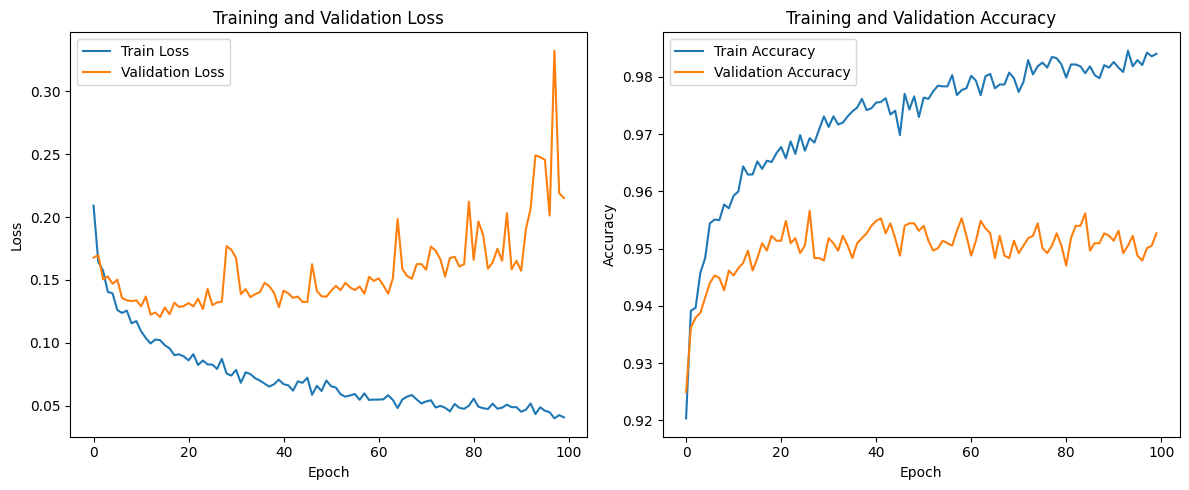

In [39]:
# Gráfico de pérdida y precisión durante el entrenamiento
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precisión de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

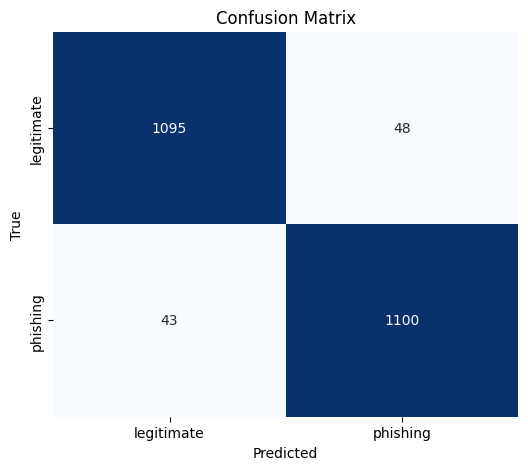

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluar el modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    y_pred = torch.round(model(val_input_tensor.to(device))).cpu().numpy()

# Convertir a etiquetas binarias (0 o 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Visualizar la matriz de confusión
plot_confusion_matrix(y_test['status'].values, y_pred_binary.flatten())

El modelo de red neuronal para predecir si una página web es phishing o no es phishing, se creó utilizando un conjunto de datos que contiene características relacionadas con las páginas web. El modelo se entrena para clasificar las páginas web en dos categorías ('status' binario). La tarea es un problema de clasificación binaria y el modelo se entrena para aprender patrones en los datos que puedan ayudar en la predicción de la etiqueta de phishing.